# Load The Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import logging

from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv("data_for_ml.csv")
df.head(3)

,Customer_Rating,Number_of_Stars,Price,Accommodation_Score,City_Antalya,City_Balıkesir,City_Muğla,City_Others
0,8.4,4,601.910,50,1,0,0,0
1,9.5,5,452.574,85,1,0,0,0
2,9.4,5,441.000,95,1,0,0,0


# Target, Feautures and Train-Test

In [4]:
y=df.pop("Price")

In [5]:
X = df

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Gradient Boosting Regression

In [7]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING) 

                                                                                    # Optimization function
def objective(trial):
                                                                                    # Define the ranges of hyperparameters for GradientBoostingRegressor
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

                                                                                    # GradientBoostingRegressor model
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=44
    )

                                                                                    # Measure the performance of the model with cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
    return np.mean(scores)

                                                                                    # Start optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600, n_jobs=-1, show_progress_bar=True)

                                                                                    # Best hyperparameters
print("Best parameters:", study.best_params)
print("Best cross-validation MSE:", -study.best_value)

best_params = study.best_params

Best trial: 48. Best value: -5394.45: 100%|█████████████████████████| 50/50 [01:39<00:00,  2.00s/it, 99.93/600 seconds]

Best parameters: {'n_estimators': 318, 'learning_rate': 0.041543828247181544, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 11, 'subsample': 0.559120256924569}
Best cross-validation MSE: 5394.453242318579
CPU times: total: 1min 58s
Wall time: 1min 39s


In [8]:
gBoost = GradientBoostingRegressor(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    subsample=best_params["subsample"],
    random_state=44
)

gBoost.fit(X_train, y_train)
y_gBoost_pred = gBoost.predict(X_test)

In [9]:
# PERFORMANCE OF GBOOST 

#cross valudation
from sklearn.model_selection import cross_val_score
cv_gBoost = cross_val_score(gBoost, X_train, y_train, cv = 10)   
n = cv_gBoost.mean()

#r2 score for train
from sklearn.metrics import r2_score
# r2 score train datası için
y_pred_gBoost_train = gBoost.predict(X_train)    
r2_score_gBoost_train = r2_score(y_train, y_pred_gBoost_train) 

# r2 score for test 
y_pred_gBoost_test = gBoost.predict(X_test)     
r2_score_gBoost_test = r2_score(y_test, y_pred_gBoost_test) 

# Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
mse_gBoost = mean_squared_error(y_test, y_pred_gBoost_test) 

# Root Mean Squared Error (RMSE)
rmse_gBoost = (np.sqrt(mean_squared_error(y_test, y_pred_gBoost_test))) 

# Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae_gBoost=  mean_absolute_error(y_test, y_pred_gBoost_test)

print("CV: ", n)
print('R2_score (train): ', r2_score_gBoost_train)
print('R2_score (test): ', r2_score_gBoost_test)
print("MSE: ", mse_gBoost)
print("RMSE: ", rmse_gBoost)
print("MAE: ", mae_gBoost)
print("------------------------------------------------")
print(cv_gBoost) 

CV:  0.6571431226312717
R2_score (train):  0.7900025558450141
R2_score (test):  0.7098252750332487
MSE:  3679.751726197834
RMSE:  60.66095718168181
MAE:  39.71778699213151
------------------------------------------------
[0.86713731 0.60156386 0.64509908 0.56687275 0.29740313 0.809479
 0.73243113 0.77421594 0.49905329 0.77817573]


# Lasso Regression

In [10]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
                                                                        # Optimization function
def objective(trial):
                                                                        # Hyperparameters for Polynomial Regression
    degree = trial.suggest_int("degree", 1, 3)
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)

 
    model = Pipeline([
        ('scaler', StandardScaler()),
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lasso", Lasso(alpha=alpha, max_iter=1000000))
    ])

                                                                        # Measure the performance of the model with cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
    return np.mean(scores)

                                                                        # Start optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600,  n_jobs=-1, show_progress_bar=True)

                                                                        # Best hyperparameters
print("Best parameters:", study.best_params)
print("Best cross-validation MSE:", -study.best_value)

best_params = study.best_params

Best trial: 18. Best value: -4989.57: 100%|█████████████████████████| 50/50 [00:24<00:00,  2.02it/s, 24.69/600 seconds]

Best parameters: {'degree': 3, 'alpha': 8.044873019606678}
Best cross-validation MSE: 4989.572204795409
CPU times: total: 40.9 s
Wall time: 24.7 s


In [11]:
lasso = Pipeline([
    ('scaler', StandardScaler()),
    ("poly_features", PolynomialFeatures(degree=best_params["degree"], include_bias=False)),
    ("lasso", Lasso(alpha=best_params["alpha"], max_iter=10000))
])

lasso.fit(X_train, y_train)
y_lasso_pred= lasso.predict(X_test)

In [12]:
# PERFORMANCE OF LASSO

#cross valudation
from sklearn.model_selection import cross_val_score
cv_lasso = cross_val_score(lasso, X_train, y_train, cv = 10) 
d = cv_lasso.mean()

#r2 for train
from sklearn.metrics import r2_score
# r2 score train datası için
y_pred_lasso_train = lasso.predict(X_train)  
r2_score_lasso_train = r2_score(y_train, y_pred_lasso_train) 

# r2 score for test 
y_pred_lasso_test = lasso.predict(X_test) 
r2_score_lasso_test = r2_score(y_test, y_pred_lasso_test) 

# Mean Squared Error (MSE)    
from sklearn.metrics import mean_squared_error
mse_lasso = mean_squared_error(y_test, y_lasso_pred) 

# rmse hesaplama      
rmse_lasso = (np.sqrt(mean_squared_error(y_test, y_lasso_pred))) 

# mae  
from sklearn.metrics import mean_absolute_error
mae_lasso =  mean_absolute_error(y_test, y_lasso_pred)


print("CV: ", d)
print('R2_score (train): ', r2_score_lasso_train)
print('R2_score (test): ', r2_score_lasso_test)
print("MSE: ", mse_lasso)
print("RMSE: ", rmse_lasso)
print("MAE: ", mae_lasso)
print("------------------------------------------------")
print(cv_lasso) 

CV:  0.6958043614431475
R2_score (train):  0.7217769095682314
R2_score (test):  0.6859488171297268
MSE:  3982.5328770924943
RMSE:  63.10731239002731
MAE:  42.733202436458036
------------------------------------------------
[0.84063741 0.70785064 0.70930593 0.61772447 0.27553417 0.65897503
 0.8448448  0.85032258 0.6004235  0.8524251 ]


# KNN Regression

In [13]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING) 
                                                                            # Optimization function
def objective(trial):
                                                                            # Ranges of hyperparameters for KNN
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 2)

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p))
    ])

                                                                            # Measure the performance of the model with cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
    return np.mean(scores)

                                                                            # Start optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600, n_jobs=-1, show_progress_bar=True)

                                                                            # Best hyperparameters
print("Best parameters:", study.best_params)
print("Best cross-validation MSE:", -study.best_value)

best_params = study.best_params

Best trial: 5. Best value: -5095.08: 100%|███████████████████████████| 50/50 [00:03<00:00, 13.59it/s, 3.59/600 seconds]

Best parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}
Best cross-validation MSE: 5095.078681424566
CPU times: total: 3.81 s
Wall time: 3.68 s


In [14]:
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(
    n_neighbors=best_params["n_neighbors"],
    weights=best_params["weights"],
    p=best_params["p"]))

    ])

knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)

In [15]:
# PERFORMANCE OF KNN 

# cross valudation
from sklearn.model_selection import cross_val_score
cv_knn = cross_val_score(knn, X_train, y_train, cv = 10)   
j = cv_knn.mean()

#r2 for train
from sklearn.metrics import r2_score
# r2 score train datası için
y_pred_knn_train = knn.predict(X_train)     # X_train_scaled
r2_score_knn_train = r2_score(y_train, y_pred_knn_train) 

# r2 score for test 
y_pred_knn_test = knn.predict(X_test)     # # X_test_scaled
r2_score_knn_test = r2_score(y_test, y_pred_knn_test) 

# Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
mse_knn = mean_squared_error(y_test, y_pred_knn_test) 

# Root Mean Squared Error (RMSE)
rmse_knn = (np.sqrt(mean_squared_error(y_test, y_pred_knn_test))) 

# Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae_knn=  mean_absolute_error(y_test, y_pred_knn_test)

print("CV: ", j)
print('R2_score (train): ', r2_score_knn_train)
print('R2_score (test): ', r2_score_knn_test)
print("MSE: ", mse_knn)
print("RMSE: ", rmse_knn)
print("MAE: ", mae_knn)
print("------------------------------------------------")
print(cv_knn) 

CV:  0.6357142475142534
R2_score (train):  0.9525615379691883
R2_score (test):  0.7047472373998416
MSE:  3744.1471271045407
RMSE:  61.18943640126571
MAE:  40.33007654749041
------------------------------------------------
[0.71823919 0.65738308 0.48939717 0.53376367 0.50246788 0.56879365
 0.85261732 0.76717338 0.50333185 0.76397528]


# Hatalar

In [16]:
models = [('Gradient Boosting Regression', cv_gBoost.mean(), r2_score_gBoost_train, r2_score_gBoost_test, mse_gBoost, rmse_gBoost, mae_gBoost),         
          ('Lasso Regression', cv_lasso.mean(), r2_score_lasso_train, r2_score_lasso_test, mse_lasso, rmse_lasso, mae_lasso),
          ('KNN Regression', cv_knn.mean(), r2_score_knn_train, r2_score_knn_test, mse_knn, rmse_knn, mae_knn)
         ]            

In [17]:
performance_comparison = pd.DataFrame(models, columns=['Model','Cross-Validation', 'R2_Score(training)', 'R2_Score(test)','MSE', 'RMSE', 'MAE'])
performance_comparison

,Model,Cross-Validation,R2_Score(training),R2_Score(test),MSE,RMSE,MAE
0,Gradient Boosting Regression,0.657143,0.790003,0.709825,3679.751726,60.660957,39.717787
1,Lasso Regression,0.695804,0.721777,0.685949,3982.532877,63.107312,42.733202
2,KNN Regression,0.635714,0.952562,0.704747,3744.147127,61.189436,40.330077


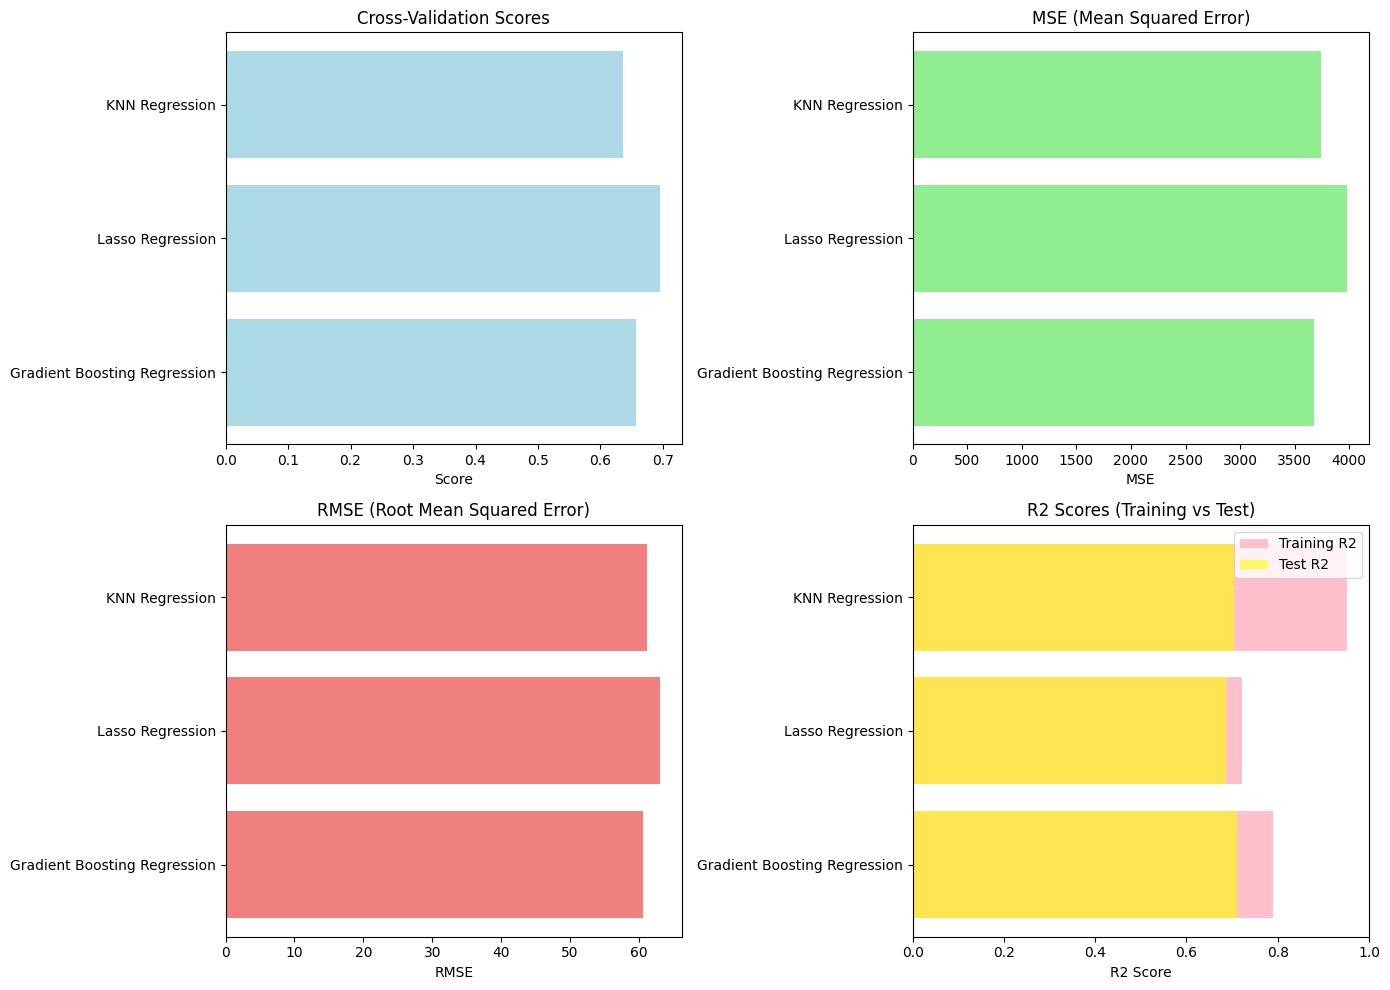

In [18]:
# Chart 1: Multiple bar chart to compare all performance metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cross-Validation scores
axes[0, 0].barh(performance_comparison['Model'], performance_comparison['Cross-Validation'], color='lightblue')
axes[0, 0].set_title('Cross-Validation Scores')
axes[0, 0].set_xlabel('Score')

# MSE
axes[0, 1].barh(performance_comparison['Model'], performance_comparison['MSE'], color='lightgreen')
axes[0, 1].set_title('MSE (Mean Squared Error)')
axes[0, 1].set_xlabel('MSE')

# RMSE
axes[1, 0].barh(performance_comparison['Model'], performance_comparison['RMSE'], color='lightcoral')
axes[1, 0].set_title('RMSE (Root Mean Squared Error)')
axes[1, 0].set_xlabel('RMSE')

# R2 Scores
axes[1, 1].barh(performance_comparison['Model'], performance_comparison['R2_Score(training)'], color='pink', label='Training R2')
axes[1, 1].barh(performance_comparison['Model'], performance_comparison['R2_Score(test)'], color='yellow', alpha=0.6, label='Test R2')
axes[1, 1].set_title('R2 Scores (Training vs Test)')
axes[1, 1].set_xlabel('R2 Score')
axes[1, 1].legend()

plt.tight_layout()
plt.show()